# Importance Sampling: A Simple Example

In [3]:
%matplotlib inline

from __future__ import division

import numpy as np
from scipy.stats import norm, uniform

import pandas as p
import matplotlib.pyplot as plt

plt.style.use('bmh')
np.random.seed(1234)

Consider the set identified posterior $\theta$:

$$
\pi(\theta) = \Phi_N \left( \frac{\theta - \bar{\phi}}{\sqrt{\bar{V}_\phi}} \right) - \Phi_N \left( \frac{\theta - 1 - \bar{\phi}}{\sqrt{\bar{V}_\phi}} \right).
$$

We can generate $\pi(\cdot)$ for varying $\bar\phi$ and $\bar V_{\phi}$ using the following function. 

In [4]:
def f(x, phibar=-0.5, Vbar=0.25):
    """
    Posterior distribution of the set identified parameter theta.
    See Equation (3.40) in the text.
    """
    phi1 = norm.cdf( (x - phibar)/np.sqrt(Vbar) )
    phi2 = norm.cdf( (x - 1.0 - phibar)/np.sqrt(Vbar) )
    return phi1 - phi2

$\bar V_{\phi}$ controls the curvature around the mode of the posterior.  This can be seen in the plot below, which plots $\pi$ for $\bar V_{\phi}\in\{1/4,1/20,1/100\}$.

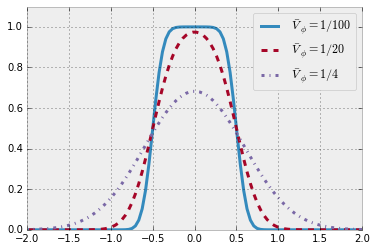

In [5]:
x = np.linspace(2, -2, 100)
f1 = f(x, Vbar=1/20)
f2 = f(x)
f3 = f(x, Vbar=1/100)

fig, ax = plt.subplots()

ax.plot(x, f3, linewidth=3)
ax.plot(x, f1, linestyle='dashed', linewidth=3)
ax.plot(x, f2, linestyle='-.', linewidth=3)
ax.set_ylim(0, 1.1)
_ = ax.legend(map(r'$\bar V_{{\phi}} ={}$'.format,['1/100','1/20','1/4']))


Instead of attempting to sample directly from the posterior
$\pi(\theta)$, we could approximate $\pi(\cdot)$ by using a different,
tractable density $g(\theta)$ that is easy to sample from and then
reweight the draws.  This approach is called _importance sampling_.
Because in many applications the posterior density can only be
evaluated up to a constant of proportionality, we write

$$
\pi(\theta) = \frac{f(\theta)}{Z}.
$$

As noted in the text, the efficacy of this approach is related to the
"closeness" of $f$ and $g$.  In what follows we consider trying to
importance sample the posterior $\pi$ induced with $\bar V_{\phi} = 1/100$
for different $g$s.

We consider two importance sampling densities. Both are centered at
$\theta=0.5$.  The first density ("concentrated", $g_c$) has a variance of
0.125, whereas the second density ("diffuse", $g_d$) has a larger variance of
0.5. The concentrated importance sampling density assigns a very small
probability to the interval $[-0.5, -0.25]$ which has a large
probability under the posterior distribution.  We plot the two $g$s
below along with $\pi$.

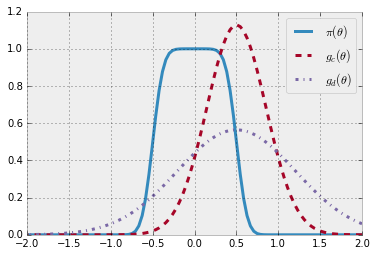

In [6]:
gc = norm(loc=0.5, scale=np.sqrt(0.125))
gd = norm(loc=0.5, scale=np.sqrt(0.500))
gc1 = gc.pdf(x)
gd1 = gd.pdf(x)

fig, ax = plt.subplots()
ax.plot(x, f3, linewidth=3)
ax.plot(x, gc1, linewidth=3, linestyle='dashed')
ax.plot(x, gd1, linewidth=3, linestyle='-.')
ax.set_ylim(0, 1.2)
_ = ax.legend([r'$\pi(\theta)$',r'$g_{c}(\theta)$',r'$g_{d}(\theta)$'])

We'll compare the performance of importance sampling estimators to the
(typically infeasible) performance of iid sampling, which we compute
below.  We assess the estimation for two choices of $h$,

$$
h(\theta) = \theta \mbox{ and } h(\theta) = \theta^2. 
$$

As mentioned above, our central measure of the accuracy of a particular IS estimator will be it's variance relative to the an estimator generated from iid draws from $\pi$. Let $\bar h_N$ be the IS estimator of $E_\pi[h]$ for a particular $g$ using $N$ draws. The variance associated with $\bar h_{N}$ if $g=\pi$ (that is, iid draws from the true posterior) is

$$
\mathbb V_{\pi}[h]/N.
$$ 

The _inefficiency factor_ is the ratio of the variance of the IS-based estimate to one obtained from iid draws from the actual posterior,

$$
\mbox{InEff}_N = \frac{\mathbb V[\bar h_N]}{\mathbb V_{\pi}[h]/N}
$$

InEff$_{N}$ gives a measure, for a particular $N$ (and $g$ and $h$), of the loss--or in rare cases, gain--in accuracy (decrease in variance), associated with importance sampling relative to iid draws. 

As we show in the text, subject to regularity conditions, the asymptotic variance associated with the IS-estimator of $h$ is 

$$
\Omega(h) = \mathbb{V}_{g}\left[\frac{\pi}{g}(h - E_{\pi}[h])\right].
$$

This gives a natural asymptotic counterpart to InEff$_{N}$,


$$
\mbox{InEff}_\infty = \frac{\Omega(h)}{\mathbb V_{\pi}[h]}.
$$

The above equations show how the performance of any particular IS algorithm will also depend on the object of interest $h$.  An easy way to see this is that for $h(\theta) = c$, the performance of the algorithm is independent of the choice of $g$.  We'll highlight below how two different $h$s estimated with substantially different levels of accuracy. 

It is often the case that there is more than one object of interest, $h$.  A crude approximation of the asymptotic inefficiency factor is given by,

$$
1 + \mathbb V_g[\pi/g].
$$


## Assessing IS: A Monte Carlo Experiment

Direct calculation of $E_{\pi}[h]$ and $V_{\pi}[h]$ are typically infeasible (the reason for IS in the first place!), and so too are InEff$_{N}$ and InEff$_{\infty}$, so we'll rely on a Monte Carlo study examine the efficacy of IS.  First, we'll compute accurate estimates of $E_{\pi}[h]$ and $V_{\pi}[h]$ via direct sampling, as seen in the function below.

In [7]:
def direct_sample(nsim, phibar=-0.5, Vbar=0.25):
    """
    Directly sample from the set-identified posterior. 
    """
    phisim = phibar + norm.rvs(size=(nsim,))*np.sqrt(Vbar)
    return phisim + uniform.rvs(size=(nsim,))
    
thsim = direct_sample(1e7, Vbar=1/100)

Eth_direct  = np.mean(thsim)
Eth2_direct = np.mean(thsim**2)
Vth_direct  = np.std(thsim)**2
Vth2_direct = np.std(thsim**2)**2

out = "{h:}: E[h] = {:5.2f}, V[h] = {:5.2f}".format

print out(Eth_direct, Vth_direct,h='h(theta) = theta  ')
print out(Eth2_direct, Vth2_direct,h='h(theta) = theta^2')

h(theta) = theta  : E[h] =  0.00, V[h] =  0.09
h(theta) = theta^2: E[h] =  0.09, V[h] =  0.01


Using the above estimates as the "truth", we assess the accuracy of
the importance sampling estimates $\bar h_{N}$ for varying $N$ using the following Monte Carlo study.

* Given $N$ and $g$, for $i = 1,\ldots,N_{run}$,

     * Compute $\bar h_N^i$ via importance sampling.
     * Compute an estimate of the asymptotic variance of [$\Omega(h)]^i$.
     * Compare an estimate of the crude inefficiency measure.

A function which performs this MC experiment for the $h$ of interest is below.

In [8]:
from itertools import product

mc = np.array([1e2, 5e2, 1e3, 5e3, 75e2, 1e4])
def monte_carlo_experiment(g=gc, mc=mc, nrun=1000):
    """
    Runs a monte carlo experiment
    
    For every nsim in mc, do nrep replications of importance, save important estimates.
    
    """
    resdf = []
    for nsim,i in product(mc,range(nrun)):
        
        # draw theta ~ g
        thsim = g.rvs(size=(nsim,))
            
        # compute wt = f/g
        wtsim = f(thsim, Vbar=1/100)/g.pdf(thsim)
            
        # normalize
        wtsim = wtsim/np.mean(wtsim)

        # compute
        Eth = np.mean(thsim * wtsim)/np.mean(wtsim)
        Eth2 = np.mean(thsim**2 * wtsim) / np.mean(wtsim)
        
        Oth = np.std( wtsim * (thsim - Eth_direct))**2
        Oth2 = np.std( wtsim * (thsim**2 - Eth2_direct))**2
        
        Ineff =  1 + np.std(wtsim)**2
        resdict = {'nsim': nsim, 'rep': i, 'Eth': Eth, 'Eth2': Eth2,
                   'Oth': Oth, 'Oth2': Oth2, 'Ineff': Ineff}

        resdf.append(resdict)

    IS = p.DataFrame(resdf)
    IS_mean = IS.groupby('nsim').mean()
    IS_var  = IS.groupby('nsim').var()

    return IS_mean, IS_var

First, run the MC for $g = g_c$, the concentrated density.

In [9]:
IS_mean, IS_var = monte_carlo_experiment()

For each $N$, we can look at our estimates of $V[\bar h]$ for both functions. 

In [13]:
IS_var[['Eth','Eth2']]

,Eth,Eth2
nsim,,
100,0.007840,0.000552
500,0.001621,0.000129
1000,0.000913,0.000071
5000,0.000162,0.000014
7500,0.000107,0.000009
10000,0.000080,0.000007


As we would expect, the variance of the estimators decreases as $N$ increase.  Also, the variance of the estimator for $h(\theta) = \theta^2$ is much lower than the variance of the estimator for $h(\theta) = \theta$.

To make these numbers interpretable, we need to compute (estimates of) InEff$_{N}$ as discussed above.

In [14]:
IS_var['InEff_h'] = mc * IS_var['Eth'] / Vth_direct
IS_var['InEff_h2'] =  mc * IS_var['Eth2'] / Vth2_direct

IS_var[['InEff_h', 'InEff_h2']]

,InEff_h,InEff_h2
nsim,,
100,8.394709,6.066773
500,8.679128,7.074678
1000,9.772086,7.836119
5000,8.677135,7.601263
7500,8.628332,7.796763
10000,8.548168,7.431637


We see that for $h(\theta) = \theta$, the estimator under the IS algorithm using the concentrated proposal distribution has a variance that is about 9 times larger, while the variance is only about 7.5 times larger for $h(\theta) = \theta^2$.   

We can also assess how good the asymptotic approximation using $\Omega$ by comparing the mean estimates of InEff$_{\infty}$ to the their finite sample counterparts.  Below we plot both of the objects, in addition to an estimate of the crude measure of inefficiency.

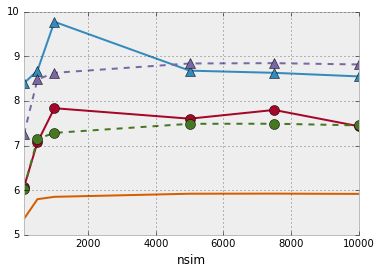

In [15]:
fig, ax = plt.subplots()
(mc * IS_var['Eth'] / Vth_direct).plot(ax=ax, marker='^', markersize=10)
(mc * IS_var['Eth2'] / Vth2_direct).plot(ax=ax, marker='o', markersize=10)
(IS_mean['Oth']/Vth_direct).plot(ax=ax, linestyle='dashed', marker='^', markersize=10)
(IS_mean['Oth2']/Vth2_direct).plot(ax=ax, linestyle='dashed', marker='o', markersize=10)
_ = IS_mean['Ineff'].plot(ax=ax)

In general, the asymptotic approximation is accurate.  While the crude measure of inefficiency, doesn't track either of the $h$-dependent measures exactly. 

We repeat the MC experiment for $g = g_d$ and create the same plot.

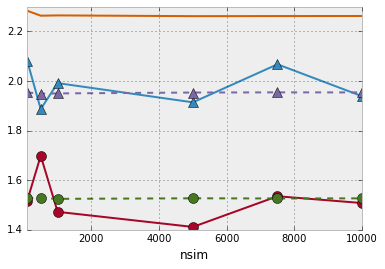

In [16]:
IS_mean, IS_var = monte_carlo_experiment(g=gd)
fig, ax = plt.subplots()
(mc * IS_var['Eth'] / Vth_direct).plot(ax=ax, marker='^', markersize=10)
(mc * IS_var['Eth2'] / Vth2_direct).plot(ax=ax, marker='o', markersize=10)
(IS_mean['Oth']/Vth_direct).plot(ax=ax, linestyle='dashed', marker='^', markersize=10)
(IS_mean['Oth2']/Vth2_direct).plot(ax=ax, linestyle='dashed', marker='o', markersize=10)
_ = IS_mean['Ineff'].plot(ax=ax)

Judging by the inefficiency factors, this we are using a much better proposal for both our $h$ functions.  This is because the concentrated density has a thin tail where $\pi$ still has substantially density.  Unlikely realizations from this density will have substantial weight, leading to volatile estimates.  On the other hand, the diffuse density has meaningful density wherever $\pi$ does, leading to more stable estimates. 